In [79]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

np.random.seed(163)

%run ./DiffusionLunarKF.ipynb
%run ./CentralizedLunarKF.ipynb

In [80]:
# variables
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5
dt = 7
sigma_uere = 0 # can't find a value for this

In [81]:
#Values from random table in Source 31
# h_0 = 1.4*(10**(-22))
# h_m1 = 2.3*(10**(-26))
# h_m2 = 3.3*(10**(-31))


#Values from sample clocks in Source 30
h_0 = 1.8*(10**(-21))
h_m1 = 6.492*(10**(-22))
h_m2 = 1.37*(10**(-24))

pi = math.pi

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*h_m2*(pi**2)*(dt**3)
e2 = 2*h_m1*dt + h_m2*((pi*dt)**2)
e3 = ((h_0/(2*dt))+ 2*h_m1 + (8/3)*(pi*pi)*h_m2*dt)

Q = (c**2)*np.array([[e1,e2],[e2,e3]])

if __name__ == '__main__':
    print(Q)

[[0.00656212 0.00087641]
 [0.00087641 0.00015093]]


In [82]:
s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
prr_var = ((c**2)/((2*pi*f_L1 * T)**2)) * (s_pll)


R = lambda N :np.block([[pr_var*np.eye(N,N),np.zeros((N,N))],[np.zeros((N,N)),prr_var*np.eye(N,N)]])
print(R(2))

[[24.40369964  0.          0.          0.        ]
 [ 0.         24.40369964  0.          0.        ]
 [ 0.          0.          0.20383392  0.        ]
 [ 0.          0.          0.          0.20383392]]


In [83]:
H_cf = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
H_20x10 = np.zeros((20, 10))
for k in range(0, 20, 4):
    H_20x10[k:k+4, k//2:k//2+2] = H_cf

R_20x20 = np.zeros((20, 20))
for i in range(0, 10):
    R_20x20[i,i] = R(1)[0][0]
for i in range(10,20):
    R_20x20[i,i] = R(1)[1][1]

measure_noise = lambda : np.linalg.cholesky(R_20x20) @ np.random.normal(np.array([[0 for _ in range(20)]]).T)

Q_10x10 = np.block([[Q[0,0]*np.eye(5),Q[0,1]*np.eye(5)],[Q[1,0]*np.eye(5),Q[1,1]*np.eye(5)]])
#Process Noise
procc_noise = lambda : np.linalg.cholesky(Q_10x10) @ np.random.normal(np.array([[0 for _ in range(10)]]).T)


In [84]:
sigma_j = 10**(-16)

In [85]:
C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])

dt = 7
c = 299792458
T_g = 0

A = np.array([  [1,0,0,0,0,dt,0,0,0,0],
                [0,1,0,0,0,0,dt,0,0,0],
                [0,0,1,0,0,0,0,dt,0,0],
                [0,0,0,1,0,0,0,0,dt,0],
                [0,0,0,0,1,0,0,0,0,dt],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,0,1,0,0,0],
                [0,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,0,1]])

n = len(C[0])
true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
# true_drifts = np.array([[0 for _ in range(n)]]).T


def get_station_truth(x,id):
    return np.array([[x[id][0]],[x[n+id][0]]])

x = c*np.vstack((true_biases,true_drifts))

# random initial estimates for each node

x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
# x0 = [np.array([[0],[0]]) for _ in range(n)]

P = [100*np.copy(R(1)) for _ in range(n)]
stations = [Station(i) for i in range(n)]

filter_initialize(stations,D,x0,P)

kf = KalmanFilter(A = A, H = H_20x10, Q = Q_10x10, R = R_20x20, x0 = x)
#For the first iteration these are our cross_links

In [86]:
iterations = 25

truth = np.zeros((iterations,2*n,1))
measurements = np.zeros((iterations,4*n,1))

raw_pred_df = np.zeros((iterations,n,2,1))
predictions_df = np.zeros((iterations,n,2,1))
updated_pred = np.zeros((iterations,n,2,1))
errors_df = np.zeros((iterations,n,2,1))
P_hist_df = np.zeros((iterations,n,2,2))

predictions_cf = [x]
errors_cf = []
P_hist_cf = []
#Process Noise

for i in range(iterations):
    #This is our new truth

    x = A@x + procc_noise()
    truth[i] = x

    T_g += dt
    true_biases = [x[:n][i]/c for i in range(n)]
    true_drifts = [x[n:][i]/c for i in range(n)]

    z = (H_20x10 @ truth[i]) + measure_noise()
    gps_measurements = [np.array([[z[2*k][0],z[2*k+1][0],z[2*(n+k)][0],z[2*(n+k)+1][0]]]).T for k in range(n)]
    measurements[i] = z

    kf.predict()
    kf.update(z) # Correct estimate using measurement

    predictions_cf.append(kf.x) # Record updated estimate and error
    errors_cf.append(kf.x - truth[i])

    P_hist_cf.append(kf.P) # Append the covariance matrix history


    if i == 0:
        time_x,gps_x,time_ests, cov_ests = diffusion_filter_iteration(
            stations,Q,R,C,gps_measurements,None,None,true_biases,true_drifts,T_g,dt,sigma_j)
    else:
       time_x,gps_x,time_ests, cov_ests = diffusion_filter_iteration(
           stations,Q,R,C,gps_measurements,time_ests,cov_ests,true_biases,true_drifts,T_g,dt,sigma_j)
    errors_df[i] = np.array([station.x - get_station_truth(x,station.id) for station in stations])
    raw_pred_df[i] = np.array(time_x)
    updated_pred[i] = np.array(gps_x)
    predictions_df[i] = np.array([stn.x for stn in stations])
    P_hist_df[i] = np.array([station.P for station in stations])


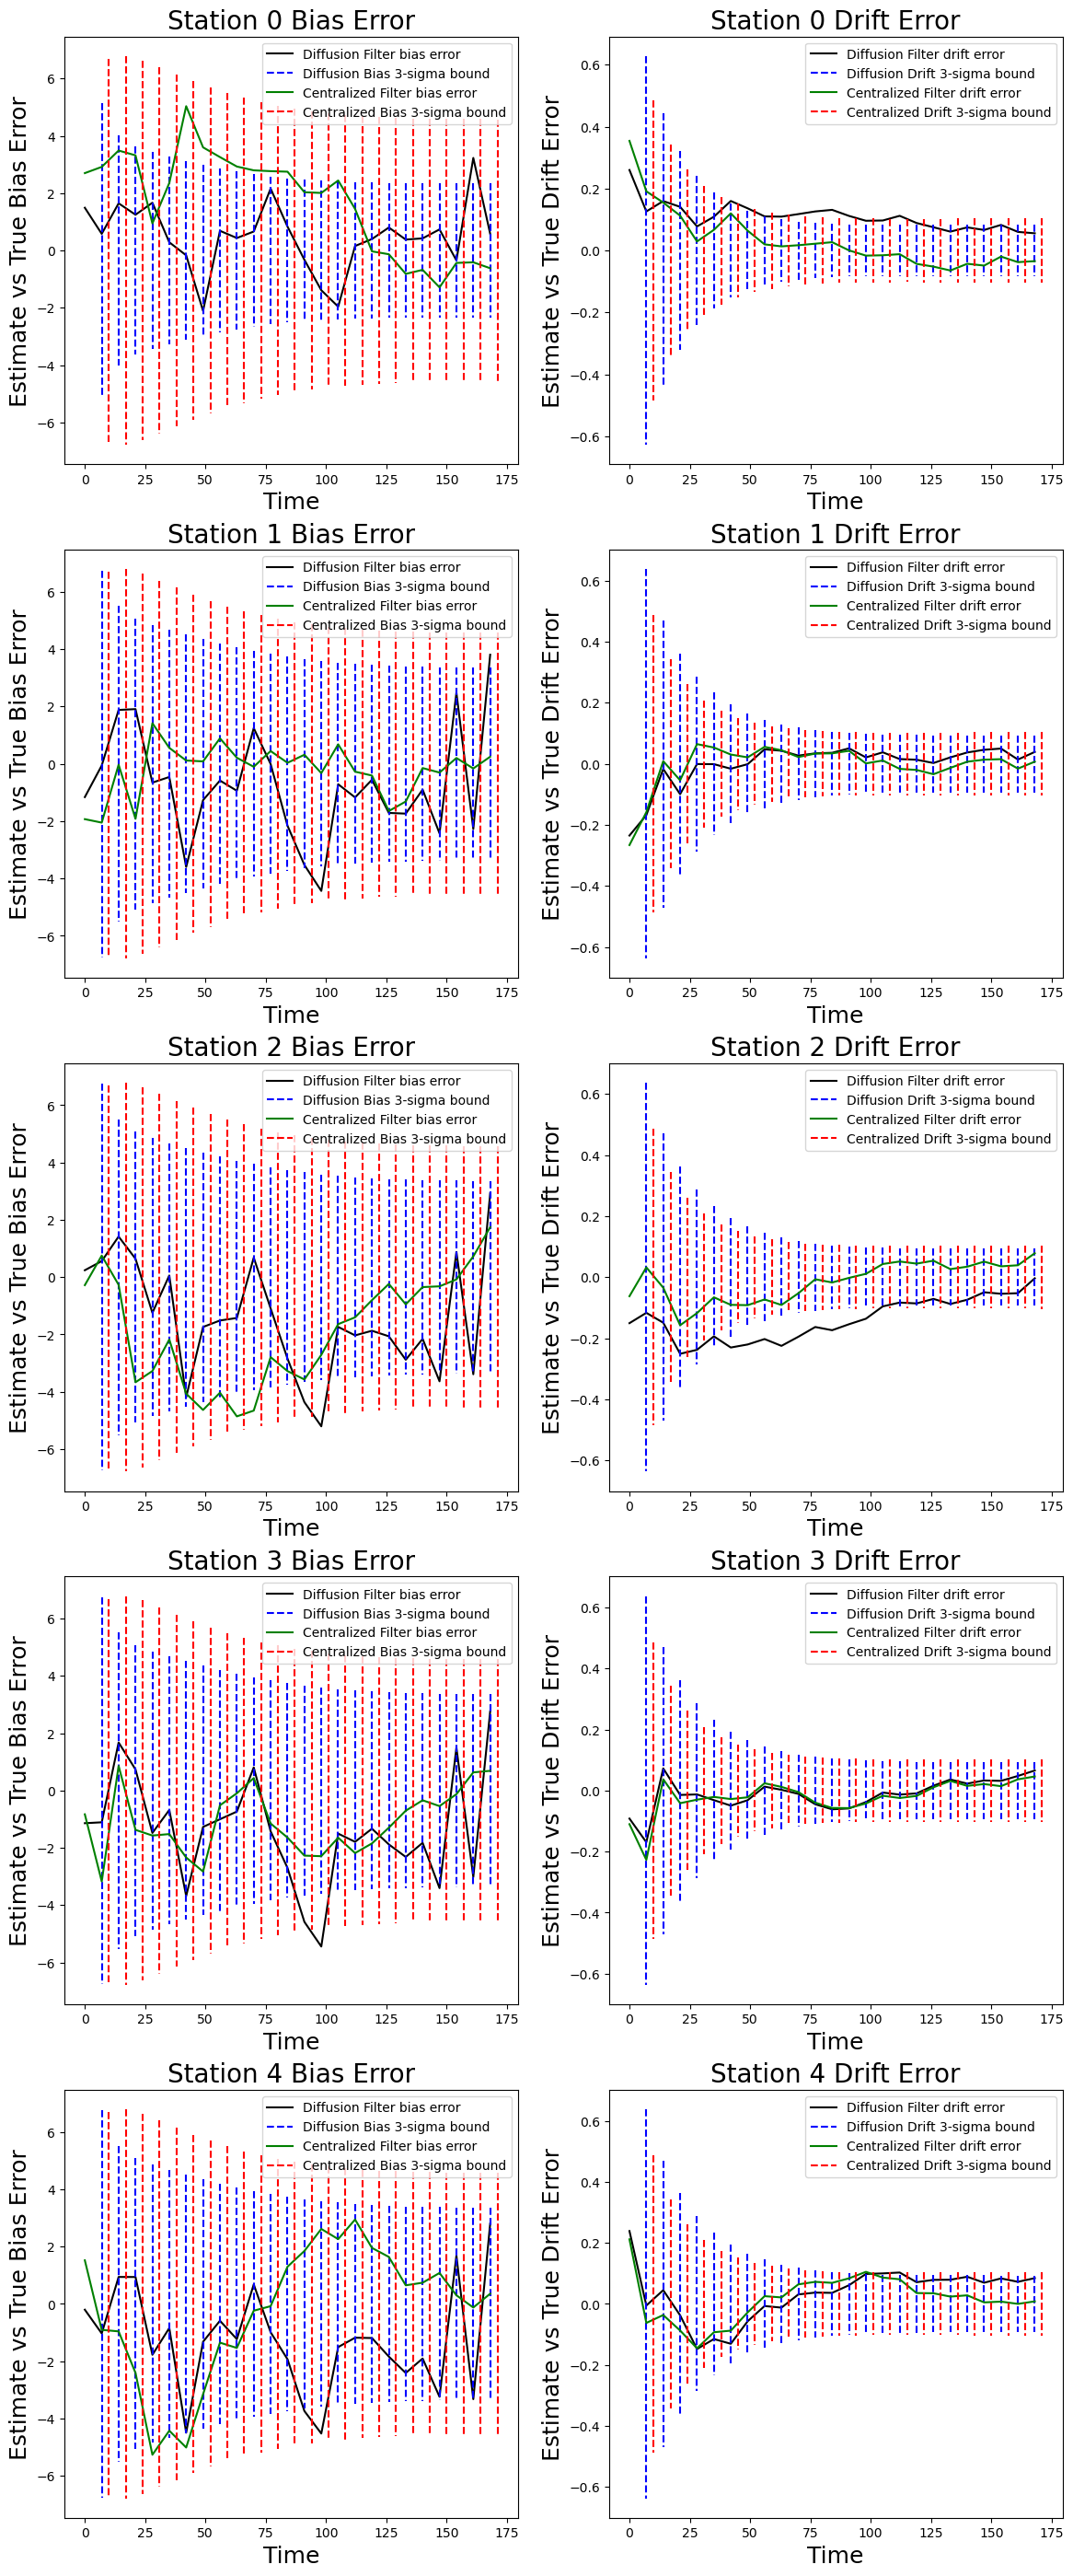

In [87]:
#Number of stations whose plots we are looking at
k = [0,1,2,3,4]

num_rows = len(k)
fig,axs = plt.subplots(num_rows,2, figsize=(14, 7*num_rows))
t_hist = np.arange(0, dt*iterations, dt)
t_hist_cf = np.arange(3, dt*iterations, dt)

errors_cf = np.array(errors_cf).squeeze()
P_hist_cf = np.array(P_hist_cf)

for inx,i in enumerate(k):
    #Diffusion Filter Error Plots
    axs[inx][0].plot(t_hist, errors_df[:, i,0,0], 'k', label = "Diffusion Filter bias error")
    bias_cov = 3*np.sqrt(P_hist_df[:, i,0,0])
    axs[inx][0].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([bias_cov[1], -bias_cov[1]]), 'b--', label = "Diffusion Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([bias_cov[2:], -bias_cov[2:]]), 'b--')
    error_bias_cf = errors_cf[:, i]
    bias_cov_k = 3*np.sqrt(P_hist_cf[:, i, i])
    axs[inx][0].plot(t_hist, error_bias_cf, label=f'Centralized Filter bias error',color = "green")
    axs[inx][0].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([bias_cov_k[1], -bias_cov_k[1]]), 'r--',label = "Centralized Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([bias_cov_k[2:], -bias_cov_k[2:]]), 'r--')
    axs[inx][0].legend()
    axs[inx][0].set_title("Station "+str(i)+" Bias Error", fontsize = 20)
    axs[inx][0].set_xlabel("Time", fontsize = 18)
    axs[inx][0].set_ylabel("Estimate vs True Bias Error", fontsize = 18)

    axs[inx][1].plot(t_hist, errors_df[:, i,1,0], 'k', label = "Diffusion Filter drift error")
    drift_cov = 3*np.sqrt(P_hist_df[:, i,1,1])
    axs[inx][1].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([drift_cov[1], -drift_cov[1]]), 'b--', label = "Diffusion Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([drift_cov[2:], -drift_cov[2:]]), 'b--')
    error_drift = errors_cf[:, n+i]
    drift_cov_k = 3*np.sqrt(P_hist_cf[:, n+i, n+i])
    axs[inx][1].plot(t_hist, error_drift, label=f'Centralized Filter drift error',color = "green")
    axs[inx][1].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([drift_cov_k[1], -drift_cov_k[1]]), 'r--', label = "Centralized Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([drift_cov_k[2:], -drift_cov_k[2:]]), 'r--')
    axs[inx][1].legend()
    axs[inx][1].set_title("Station "+str(i)+" Drift Error", fontsize = 20)
    axs[inx][1].set_xlabel("Time", fontsize = 18)
    axs[inx][1].set_ylabel("Estimate vs True Drift Error", fontsize = 18)



plt.show()